In [34]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

In [35]:
# GPU setting

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(torch.cuda.get_device_name(0)) #Google colab = TESLA T4import torch


NVIDIA GeForce RTX 2060


In [36]:
import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

In [37]:
 # Data load

df = pd.read_csv('경기도_clustered1.csv',encoding = 'cp949')

cluster = pd.read_csv('경기도_clustered1.csv',encoding = 'cp949',index_col = 0)
cluster

,수원시,성남시,안양시,부천시,광명시,안산시,고양시,과천시,구리시,남양주시,...,동두천시,이천시,안성시,여주시,포천시,의정부시,파주시,광주시,양주시,오산시
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,63.4,67.8,60.5,68.1,53.0,66.8,69.5,63.4,58.9,70.2,...,92.6,89.2,92.6,102.8,93.6,77.7,82.3,82.4,82.0,83.2
2013-02-01,63.3,67.2,60.2,67.7,52.9,66.6,69.0,63.1,58.3,69.9,...,90.9,89.4,92.8,102.8,93.6,77.4,81.9,82.0,81.7,83.0
2013-03-01,63.2,66.9,60.0,67.4,52.6,66.3,68.6,63.2,58.0,69.7,...,90.1,89.7,92.8,102.7,93.6,76.9,81.6,81.9,81.4,82.9
2013-04-01,63.3,67.1,59.8,67.4,52.6,66.3,68.1,64.5,58.1,69.6,...,90.0,90.1,93.5,102.7,93.9,76.4,80.6,82.3,81.7,82.9
2013-05-01,63.4,67.5,59.6,67.6,52.9,66.6,68.1,64.8,58.3,69.7,...,89.8,90.4,93.8,103.6,94.7,76.4,80.7,82.3,81.9,82.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-01,109.5,104.8,111.7,110.2,107.3,110.7,107.6,103.1,106.2,108.9,...,107.7,110.3,114.8,106.6,108.4,107.2,106.9,107.9,109.5,115.9
2021-12-01,109.8,105.1,112.0,110.8,107.4,111.2,108.0,103.5,106.4,109.3,...,107.5,112.3,116.1,107.2,109.0,107.4,107.2,108.4,109.8,116.7
2022-01-01,109.8,105.1,111.8,110.8,107.3,111.3,108.1,103.4,106.3,109.3,...,107.5,113.3,116.9,107.1,109.2,107.4,107.5,108.7,109.8,116.8


In [38]:
data = pd.read_csv('경기도변수.csv')
feature = pd.read_csv('경기도변수.csv',index_col = 0)

data

,date,seoul,Avg_1,Avg_2,Avg_3,MMI,CPI,대출금리,전세가격지수 전국,전세가격지수 경기도,환율,M2,코스피,코스닥,건축허용면적,거래량 전국,거래량 경기
0,2013-01-01,73.5,64.75625,93.900000,80.1,102.868,92.728,5.78,82.689331,76.007636,1089.0,1841.1,1961.90,503.67,8413721.0,54632,13631
1,2013-02-01,73.2,64.42500,93.666667,79.8,90.009,93.038,5.66,82.871183,76.108044,1083.0,1857.1,2026.50,535.87,7268443.0,65640,14925
2,2013-03-01,73.1,64.22500,93.550000,79.6,101.388,92.952,5.54,83.162722,76.376687,1111.0,1862.4,2004.90,555.02,10160177.0,87563,17718
3,2013-04-01,73.2,64.30000,93.766667,79.5,101.295,92.823,5.42,83.554044,76.858189,1101.0,1867.7,1964.00,563.87,9757932.0,106498,22790
4,2013-05-01,73.4,64.49375,94.116667,79.6,102.313,92.823,5.24,83.797077,77.090528,1129.7,1870.3,2001.05,577.87,10837979.0,120393,25910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,2021-10-01,103.5,107.45625,108.650000,108.8,114.800,103.350,3.47,102.450935,103.903947,1168.6,3543.4,2970.68,992.33,14689855.0,119686,29187
106,2021-11-01,104.1,108.45625,110.166667,109.8,119.300,103.870,3.58,102.917900,104.543227,1187.9,3594.7,2839.01,965.63,14483042.0,111172,26593
107,2021-12-01,104.4,108.79375,111.033333,110.2,126.700,104.040,3.68,103.178314,104.798091,1188.8,3620.1,2977.65,1033.98,19169150.0,101766,25669
108,2022-01-01,104.4,108.75000,111.383333,110.3,115.100,104.690,3.75,103.250891,104.790872,1205.5,3634.3,2663.34,872.87,13736304.0,87825,20544


In [39]:
train = data.copy()

In [40]:
train.corr()

,seoul,Avg_1,Avg_2,Avg_3,MMI,CPI,대출금리,전세가격지수 전국,전세가격지수 경기도,환율,M2,코스피,코스닥,건축허용면적,거래량 전국,거래량 경기
seoul,1.000000,0.909367,0.227910,0.773868,0.655650,0.985362,-0.788762,0.821937,0.833499,0.511194,0.983945,0.713424,0.804257,0.120689,0.277253,0.461072
Avg_1,0.909367,1.000000,0.430139,0.952320,0.659035,0.914310,-0.738248,0.859271,0.864163,0.454030,0.950728,0.825427,0.851910,0.213492,0.145921,0.223406
Avg_2,0.227910,0.430139,1.000000,0.636631,0.263814,0.316192,-0.263846,0.629858,0.605018,0.122268,0.258434,0.404361,0.410531,0.467495,-0.122293,-0.113604
Avg_3,0.773868,0.952320,0.636631,1.000000,0.617700,0.802606,-0.595459,0.829918,0.825010,0.352483,0.825879,0.833771,0.805576,0.255809,-0.000097,0.046835
MMI,0.655650,0.659035,0.263814,0.617700,1.000000,0.643640,-0.508876,0.590326,0.592166,0.225834,0.660918,0.590472,0.575644,0.370323,0.317967,0.355939
CPI,0.985362,0.914310,0.316192,0.802606,0.643640,1.000000,-0.788664,0.860513,0.867821,0.477902,0.977648,0.736793,0.800200,0.135486,0.252717,0.434781
대출금리,-0.788762,-0.738248,-0.263846,-0.595459,-0.508876,-0.788664,1.000000,-0.883444,-0.897772,-0.557470,-0.827397,-0.575287,-0.730375,-0.416933,-0.542016,-0.611001
전세가격지수 전국,0.821937,0.859271,0.629858,0.829918,0.590326,0.860513,-0.883444,1.000000,0.998765,0.444093,0.854004,0.738510,0.832382,0.455081,0.319727,0.411201
전세가격지수 경기도,0.833499,0.864163,0.605018,0.825010,0.592166,0.867821,-0.897772,0.998765,1.000000,0.466121,0.866091,0.732316,0.833379,0.448879,0.337487,0.429138
환율,0.511194,0.454030,0.122268,0.352483,0.225834,0.477902,-0.557470,0.444093,0.466121,1.000000,0.525141,0.032797,0.228263,0.166043,0.125236,0.225640


In [41]:
# Training/Test ratio = 7:3

Train_ratio = 0.7

Test_ratio = 0.3

In [42]:
result =  pd.DataFrame(data=[0,0,0,0],
                             index = ['MAE','RMSE','MAPE', 'R2'],
                             columns=['test'])
predict =  pd.DataFrame(data=[],columns=['test'] )
predict

,test


lag 변수 생성

In [43]:
df.set_index('date', inplace=True)
data.set_index('date', inplace=True)

In [44]:
lag_col= list(df.columns)


lag_amount = 3

for col in lag_col:
    for i in range(lag_amount):
        df['{0}_lag{1}'.format(col,i+1)] = df['{}'.format(col)].shift(i+1)
        
df.dropna(inplace=True)


In [45]:
df = df.iloc[:-3,:]
df

,수원시,성남시,안양시,부천시,광명시,안산시,고양시,과천시,구리시,남양주시,...,파주시_lag3,광주시_lag1,광주시_lag2,광주시_lag3,양주시_lag1,양주시_lag2,양주시_lag3,오산시_lag1,오산시_lag2,오산시_lag3
date,,,,,,,,,,,,,,,,,,,,,
2013-04-01,63.3,67.1,59.8,67.4,52.6,66.3,68.1,64.5,58.1,69.6,...,82.3,81.9,82.0,82.4,81.4,81.7,82.0,82.9,83.0,83.2
2013-05-01,63.4,67.5,59.6,67.6,52.9,66.6,68.1,64.8,58.3,69.7,...,81.9,82.3,81.9,82.0,81.7,81.4,81.7,82.9,82.9,83.0
2013-06-01,63.5,67.9,59.5,67.6,53.0,66.8,68.0,64.6,58.4,69.6,...,81.6,82.3,82.3,81.9,81.9,81.7,81.4,82.9,82.9,82.9
2013-07-01,63.4,67.7,59.5,67.5,53.1,66.7,67.9,64.3,58.3,69.4,...,80.6,82.2,82.3,82.3,82.1,81.9,81.7,82.4,82.9,82.9
2013-08-01,63.2,67.4,59.4,67.2,52.9,66.5,67.9,64.0,58.2,69.2,...,80.7,81.9,82.2,82.3,81.4,82.1,81.9,82.1,82.4,82.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,104.7,102.6,106.2,104.5,104.0,105.0,103.1,101.8,102.7,104.1,...,98.5,101.8,100.0,98.0,101.8,100.0,97.5,103.5,100.0,96.0
2021-09-01,106.5,103.6,108.3,106.7,105.5,107.1,105.0,102.3,104.0,106.1,...,100.0,104.1,101.8,100.0,104.2,101.8,100.0,107.3,103.5,100.0
2021-10-01,108.4,104.3,110.5,108.7,106.7,109.3,106.7,102.6,105.3,107.8,...,101.1,105.4,104.1,101.8,106.4,104.2,101.8,110.7,107.3,103.5


In [46]:
lag_col= list(data.columns)


lag_amount = 3

for col in lag_col:
    for i in range(lag_amount):
        data['{0}_lag{1}'.format(col,i+1)] = data['{}'.format(col)].shift(i+1)
        
data.dropna(inplace=True)

In [47]:
data= data.iloc[:-2,:]
data

,seoul,Avg_1,Avg_2,Avg_3,MMI,CPI,대출금리,전세가격지수 전국,전세가격지수 경기도,환율,...,코스닥_lag3,건축허용면적_lag1,건축허용면적_lag2,건축허용면적_lag3,거래량 전국_lag1,거래량 전국_lag2,거래량 전국_lag3,거래량 경기_lag1,거래량 경기_lag2,거래량 경기_lag3
date,,,,,,,,,,,,,,,,,,,,,
2013-04-01,73.2,64.30000,93.766667,79.5,101.295,92.823,5.42,83.554044,76.858189,1101.0,...,503.67,10160177.0,7268443.0,8413721.0,87563.0,65640.0,54632.0,17718.0,14925.0,13631.0
2013-05-01,73.4,64.49375,94.116667,79.6,102.313,92.823,5.24,83.797077,77.090528,1129.7,...,535.87,9757932.0,10160177.0,7268443.0,106498.0,87563.0,65640.0,22790.0,17718.0,14925.0
2013-06-01,73.2,64.55000,94.300000,79.5,99.722,92.710,5.05,83.978080,77.265688,1142.0,...,555.02,10837979.0,9757932.0,10160177.0,120393.0,106498.0,87563.0,25910.0,22790.0,17718.0
2013-07-01,72.8,64.36875,94.233333,79.1,99.907,92.909,5.09,84.230581,77.474299,1123.5,...,563.87,10007009.0,10837979.0,9757932.0,160468.0,120393.0,106498.0,33741.0,25910.0,22790.0
2013-08-01,72.5,64.17500,94.083333,78.8,96.115,93.238,5.06,84.582865,77.939035,1110.0,...,577.87,11233555.0,10007009.0,10837979.0,74944.0,160468.0,120393.0,16437.0,33741.0,25910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,101.7,104.06250,104.500000,104.7,110.500,102.750,3.32,101.225843,101.991464,1159.5,...,981.78,14591577.0,16013705.0,13891755.0,140102.0,144759.0,154949.0,39146.0,38191.0,42027.0
2021-09-01,102.7,105.82500,106.616667,106.9,111.100,103.170,3.40,101.824690,102.964829,1184.0,...,1029.96,13946424.0,14591577.0,16013705.0,133495.0,140102.0,144759.0,36154.0,39146.0,38191.0
2021-10-01,103.5,107.45625,108.650000,108.8,114.800,103.350,3.47,102.450935,103.903947,1168.6,...,1031.14,14652194.0,13946424.0,14591577.0,122333.0,133495.0,140102.0,33662.0,36154.0,39146.0


In [48]:
from tqdm.notebook import tqdm
for i in tqdm(range(28)):
    
    
    x = data.replace(',','')
    y = df.iloc[:,i:i+1]
    
       
    train_x = x.iloc[0:int(len(x)*Train_ratio),:]

    train_y = y.iloc[0:int(len(x)*Train_ratio),:]

    test_x = x.iloc[int(len(x)*Train_ratio):,:]

    test_y = y.iloc[int(len(x)*Train_ratio):,:]
    

    
    

    # Normalizing , 둘다 학습하여 성능비교할것

    minmax = MinMaxScaler()

    standard = StandardScaler()

    
    yscaler = minmax.fit(y.values.reshape(-1,1))
    train_x = minmax.fit_transform(train_x)

    train_y = minmax.fit_transform(train_y)

    test_x = minmax.fit_transform(test_x)

    test_y = minmax.fit_transform(test_y)





    # Numpy array상태로는 학습이 불가능하므로, Torch Variable 형태로 변경(data/grad/grad_fn)

    train_x_tensor = Variable(torch.Tensor(train_x))

    train_y_tensor = Variable(torch.Tensor(train_y))

    

    test_x_tensor = Variable(torch.Tensor(test_x))

    test_y_tensor = Variable(torch.Tensor(test_y))

    

    train_x_tensor_final = torch.reshape(train_x_tensor, (train_x_tensor.shape[0], 1, train_x_tensor.shape[1]))

    train_y_tensor_final = torch.reshape(train_y_tensor, (train_y_tensor.shape[0], 1, train_y_tensor.shape[1]))

    test_x_tensor_final = torch.reshape(test_x_tensor, (test_x_tensor.shape[0], 1, test_x_tensor.shape[1]))

    test_y_tensor_final = torch.reshape(test_y_tensor,(test_y_tensor.shape[0], 1, test_y_tensor.shape[1]) )

    


    ## LSTM network modeling

    class LSTM_Jun(nn.Module):

        def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) : 

            super(LSTM_Jun, self).__init__()

            self.num_classes = num_classes

            self.num_layers = num_layers

            self.input_size = input_size

            self.hidden_size = hidden_size

            self.seq_length = seq_length

            self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)

            self.layer_1 = nn.Linear(hidden_size, 256)

            self.layer_2 = nn.Linear(256,256)

            self.layer_3 = nn.Linear(256,128)

            self.layer_out = nn.Linear(128, num_classes)

            self.relu = nn.ReLU() #Activation Func

        def forward(self,x):

            h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #Hidden State

            c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #Internal Process States



            output, (hn, cn) = self.lstm(x, (h_0, c_0))



            hn = hn.view(-1, self.hidden_size) # Reshaping the data for starting LSTM network

            out = self.relu(hn) #pre-processing for first layer

            out = self.layer_1(out) # first layer

            out = self.relu(out) # activation func relu

            out = self.layer_2(out)

            out = self.relu(out)

            out = self.layer_3(out)

            out = self.relu(out)

            out = self.layer_out(out) #Output layer

            return out

 

    # Code Main

    num_epochs = 1000
    learning_rate = 0.005

    input_size = int(len(x.columns))

    hidden_size = 2 # number of features in hidden state

    num_layers = 1

    num_classes = int(len(y.columns))



    model = LSTM_Jun(num_classes, input_size, hidden_size, num_layers, train_x_tensor_final.shape[1]).to(device)



    loss_function = torch.nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

 

    for epoch in range(num_epochs) : 

        outputs = model.forward(train_x_tensor_final.to(device))

        optimizer.zero_grad()

        loss = loss_function(outputs, train_y_tensor.to(device))

        loss.backward()

        optimizer.step() # improve from loss = back propagation

        if epoch % 100 == 0 :

            print("Epoch : %d, loss : %1.5f" % (epoch, loss.item()))
            

    # Estimated Value

    test_predict = model(test_x_tensor_final.to(device)) #Forward Pass

    predict_data = test_predict.data.detach().cpu().numpy() #numpy conversion

    predict_data = minmax.inverse_transform(predict_data) #inverse normalization(Min/Max)
    
    y_pred = predict_data[:,0]

    # Real Value

    real_data = test_y_tensor.data.numpy() # Real value

    real_data = minmax.inverse_transform(real_data) #inverse normalization 
    
    y_test = real_data[:,0]

    
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
    MAPE= np.mean(np.abs((y_test - y_pred) / y_test))
    pd.options.display.float_format = '{:.5f}'.format
    
    label = df.columns[i]
    Result = pd.DataFrame(data=[MAE,RMSE, MAPE,R2],
                         index = ['MAE','RMSE','MAPE','R2'],
                         columns=[label])
        
    

    result = pd.concat([result,Result],axis = 1)

    DAYS_TO_PREDICT = 6
    with torch.no_grad():
        test_seq = test_x_tensor_final[:-1].to(device)
        

        preds = []
        for i in range(DAYS_TO_PREDICT):
            y_test_pred = model(test_seq.to(device))[-1:,0]
                      
            pred = torch.flatten(y_test_pred).item()
            preds.append(pred)
            new_seq = test_seq.data.detach().cpu().numpy().flatten()
            new_seq = np.append(new_seq, [pred])
            new_seq = new_seq[1:]
            test_seq = torch.as_tensor(new_seq).view(test_x_tensor_final[:-1].shape[0],1,test_x_tensor_final[:-1].shape[2]).float()


    # Prediction value 스케일링 역변환
    pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))
    pred_values

    # 예측값 반올림
    import math

    pred_values_ceiled = list(pred_values.flatten())
    predicted_cases=pred_values_ceiled
    predicted_cases

    predicted_index = pd.date_range(
      start=data.index[-1],
      periods=DAYS_TO_PREDICT + 1, freq = 'MS',
      closed='right'
    )

    predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

    predicted_cases_i = pd.DataFrame(
      data=predicted_cases,
      index=predicted_index,
        columns = [label]
    )
    
    if not i :
        predict = predicted_cases_i
    else:
        predict =pd.concat([predict,predicted_cases_i],axis = 1)

    preds_i = pd.DataFrame(predicted_cases_i)
    feature.index = pd.to_datetime(feature.index)

    y_i = pd.DataFrame(data =df[df.columns[i]].values,index = df.index)
    y_i.index.name = ''

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch : 0, loss : 0.39275
Epoch : 100, loss : 0.00298
Epoch : 200, loss : 0.00140
Epoch : 300, loss : 0.00078
Epoch : 400, loss : 0.00059
Epoch : 500, loss : 0.00047
Epoch : 600, loss : 0.00037
Epoch : 700, loss : 0.00030
Epoch : 800, loss : 0.00025
Epoch : 900, loss : 0.00021


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.26988
Epoch : 100, loss : 0.00272
Epoch : 200, loss : 0.00087
Epoch : 300, loss : 0.00066
Epoch : 400, loss : 0.00051
Epoch : 500, loss : 0.00045
Epoch : 600, loss : 0.00045
Epoch : 700, loss : 0.00039
Epoch : 800, loss : 0.00035
Epoch : 900, loss : 0.00031


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.32270
Epoch : 100, loss : 0.00083
Epoch : 200, loss : 0.00037
Epoch : 300, loss : 0.00028
Epoch : 400, loss : 0.00021
Epoch : 500, loss : 0.00018
Epoch : 600, loss : 0.00015
Epoch : 700, loss : 0.00013
Epoch : 800, loss : 0.00012
Epoch : 900, loss : 0.00032


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.43482
Epoch : 100, loss : 0.00062
Epoch : 200, loss : 0.00024
Epoch : 300, loss : 0.00011
Epoch : 400, loss : 0.00005
Epoch : 500, loss : 0.00006
Epoch : 600, loss : 0.00004
Epoch : 700, loss : 0.00003
Epoch : 800, loss : 0.00008
Epoch : 900, loss : 0.00003


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.31127
Epoch : 100, loss : 0.00052
Epoch : 200, loss : 0.00017
Epoch : 300, loss : 0.00011
Epoch : 400, loss : 0.00008
Epoch : 500, loss : 0.00006
Epoch : 600, loss : 0.00005
Epoch : 700, loss : 0.00004
Epoch : 800, loss : 0.00007
Epoch : 900, loss : 0.00023


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.58941
Epoch : 100, loss : 0.00115
Epoch : 200, loss : 0.00027
Epoch : 300, loss : 0.00019
Epoch : 400, loss : 0.00015
Epoch : 500, loss : 0.00014
Epoch : 600, loss : 0.00011
Epoch : 700, loss : 0.00010
Epoch : 800, loss : 0.00009
Epoch : 900, loss : 0.00077


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.46761
Epoch : 100, loss : 0.00129
Epoch : 200, loss : 0.00070
Epoch : 300, loss : 0.00039
Epoch : 400, loss : 0.00024
Epoch : 500, loss : 0.00021
Epoch : 600, loss : 0.00016
Epoch : 700, loss : 0.00006
Epoch : 800, loss : 0.00006
Epoch : 900, loss : 0.00021


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.31685
Epoch : 100, loss : 0.08060
Epoch : 200, loss : 0.08060
Epoch : 300, loss : 0.08060
Epoch : 400, loss : 0.08060
Epoch : 500, loss : 0.08060
Epoch : 600, loss : 0.08060
Epoch : 700, loss : 0.08060
Epoch : 800, loss : 0.08060
Epoch : 900, loss : 0.08060


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.17782
Epoch : 100, loss : 0.00321
Epoch : 200, loss : 0.00100
Epoch : 300, loss : 0.00037
Epoch : 400, loss : 0.00057
Epoch : 500, loss : 0.00030
Epoch : 600, loss : 0.00014
Epoch : 700, loss : 0.00038
Epoch : 800, loss : 0.00006
Epoch : 900, loss : 0.00015


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.51681
Epoch : 100, loss : 0.00148
Epoch : 200, loss : 0.00096
Epoch : 300, loss : 0.00073
Epoch : 400, loss : 0.00057
Epoch : 500, loss : 0.00042
Epoch : 600, loss : 0.00035
Epoch : 700, loss : 0.00072
Epoch : 800, loss : 0.00036
Epoch : 900, loss : 0.00027


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.41503
Epoch : 100, loss : 0.00492
Epoch : 200, loss : 0.00430
Epoch : 300, loss : 0.00417
Epoch : 400, loss : 0.00172
Epoch : 500, loss : 0.00146
Epoch : 600, loss : 0.00101
Epoch : 700, loss : 0.00050
Epoch : 800, loss : 0.00044
Epoch : 900, loss : 0.00046


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.53365
Epoch : 100, loss : 0.00189
Epoch : 200, loss : 0.00105
Epoch : 300, loss : 0.00072
Epoch : 400, loss : 0.00061
Epoch : 500, loss : 0.00056
Epoch : 600, loss : 0.00050
Epoch : 700, loss : 0.00047
Epoch : 800, loss : 0.00055
Epoch : 900, loss : 0.00042


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.28441
Epoch : 100, loss : 0.00124
Epoch : 200, loss : 0.00046
Epoch : 300, loss : 0.00014
Epoch : 400, loss : 0.00020
Epoch : 500, loss : 0.00007
Epoch : 600, loss : 0.00006
Epoch : 700, loss : 0.00005
Epoch : 800, loss : 0.00005
Epoch : 900, loss : 0.00066


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.21752
Epoch : 100, loss : 0.07454
Epoch : 200, loss : 0.07454
Epoch : 300, loss : 0.07454
Epoch : 400, loss : 0.07454
Epoch : 500, loss : 0.07454
Epoch : 600, loss : 0.07454
Epoch : 700, loss : 0.07457
Epoch : 800, loss : 0.07454
Epoch : 900, loss : 0.07454


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.47303
Epoch : 100, loss : 0.00319
Epoch : 200, loss : 0.00155
Epoch : 300, loss : 0.00098
Epoch : 400, loss : 0.00233
Epoch : 500, loss : 0.00049
Epoch : 600, loss : 0.00039
Epoch : 700, loss : 0.00031
Epoch : 800, loss : 0.00024
Epoch : 900, loss : 0.00019


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.37414
Epoch : 100, loss : 0.00241
Epoch : 200, loss : 0.00162
Epoch : 300, loss : 0.00110
Epoch : 400, loss : 0.00111
Epoch : 500, loss : 0.00086
Epoch : 600, loss : 0.00072
Epoch : 700, loss : 0.00078
Epoch : 800, loss : 0.00101
Epoch : 900, loss : 0.00048


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.35299
Epoch : 100, loss : 0.00224
Epoch : 200, loss : 0.00116
Epoch : 300, loss : 0.00060
Epoch : 400, loss : 0.00042
Epoch : 500, loss : 0.00030
Epoch : 600, loss : 0.00027
Epoch : 700, loss : 0.00024
Epoch : 800, loss : 0.00022
Epoch : 900, loss : 0.00024


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.52190
Epoch : 100, loss : 0.00178
Epoch : 200, loss : 0.00085
Epoch : 300, loss : 0.00058
Epoch : 400, loss : 0.00043
Epoch : 500, loss : 0.00061
Epoch : 600, loss : 0.00033
Epoch : 700, loss : 0.00067
Epoch : 800, loss : 0.00028
Epoch : 900, loss : 0.00025


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.35536
Epoch : 100, loss : 0.00325
Epoch : 200, loss : 0.00140
Epoch : 300, loss : 0.00078
Epoch : 400, loss : 0.00045
Epoch : 500, loss : 0.00032
Epoch : 600, loss : 0.00027
Epoch : 700, loss : 0.00022
Epoch : 800, loss : 0.00025
Epoch : 900, loss : 0.00016


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.45726
Epoch : 100, loss : 0.00236
Epoch : 200, loss : 0.00052
Epoch : 300, loss : 0.00028
Epoch : 400, loss : 0.00020
Epoch : 500, loss : 0.00017
Epoch : 600, loss : 0.00014
Epoch : 700, loss : 0.00013
Epoch : 800, loss : 0.00011
Epoch : 900, loss : 0.00010


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.44620
Epoch : 100, loss : 0.00141
Epoch : 200, loss : 0.00071
Epoch : 300, loss : 0.00047
Epoch : 400, loss : 0.00034
Epoch : 500, loss : 0.00026
Epoch : 600, loss : 0.00021
Epoch : 700, loss : 0.00017
Epoch : 800, loss : 0.00019
Epoch : 900, loss : 0.00075


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.51844
Epoch : 100, loss : 0.00155
Epoch : 200, loss : 0.00050
Epoch : 300, loss : 0.00026
Epoch : 400, loss : 0.00020
Epoch : 500, loss : 0.00019
Epoch : 600, loss : 0.00015
Epoch : 700, loss : 0.00012
Epoch : 800, loss : 0.00023
Epoch : 900, loss : 0.00025


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.44688
Epoch : 100, loss : 0.00285
Epoch : 200, loss : 0.00067
Epoch : 300, loss : 0.00029
Epoch : 400, loss : 0.00022
Epoch : 500, loss : 0.00020
Epoch : 600, loss : 0.00013
Epoch : 700, loss : 0.00010
Epoch : 800, loss : 0.00014
Epoch : 900, loss : 0.00007


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.62904
Epoch : 100, loss : 0.00154
Epoch : 200, loss : 0.00033
Epoch : 300, loss : 0.00022
Epoch : 400, loss : 0.00020
Epoch : 500, loss : 0.00021
Epoch : 600, loss : 0.00007
Epoch : 700, loss : 0.00007
Epoch : 800, loss : 0.00005
Epoch : 900, loss : 0.00009


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.47294
Epoch : 100, loss : 0.00304
Epoch : 200, loss : 0.00173
Epoch : 300, loss : 0.00117
Epoch : 400, loss : 0.00091
Epoch : 500, loss : 0.00226
Epoch : 600, loss : 0.00070
Epoch : 700, loss : 0.00060
Epoch : 800, loss : 0.00050
Epoch : 900, loss : 0.00084


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.38852
Epoch : 100, loss : 0.00675
Epoch : 200, loss : 0.00530
Epoch : 300, loss : 0.00075
Epoch : 400, loss : 0.00059
Epoch : 500, loss : 0.00053
Epoch : 600, loss : 0.00051
Epoch : 700, loss : 0.00067
Epoch : 800, loss : 0.00044
Epoch : 900, loss : 0.00042


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.34975
Epoch : 100, loss : 0.00183
Epoch : 200, loss : 0.00136
Epoch : 300, loss : 0.00113
Epoch : 400, loss : 0.00098
Epoch : 500, loss : 0.00085
Epoch : 600, loss : 0.00077
Epoch : 700, loss : 0.00071
Epoch : 800, loss : 0.00067
Epoch : 900, loss : 0.00064


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


Epoch : 0, loss : 0.43552
Epoch : 100, loss : 0.00587
Epoch : 200, loss : 0.00420
Epoch : 300, loss : 0.00399
Epoch : 400, loss : 0.00408
Epoch : 500, loss : 0.00387
Epoch : 600, loss : 0.00385
Epoch : 700, loss : 0.00383
Epoch : 800, loss : 0.00189
Epoch : 900, loss : 0.00181


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10084\2659646056.py:234: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


In [49]:
del result['test']
result
result.to_csv('평가지표.csv',encoding='cp949')

In [50]:
del predict['test']

predict.to_csv('예측치.csv',encoding='cp949')
predict

,수원시,성남시,안양시,부천시,광명시,안산시,고양시,과천시,구리시,남양주시,...,동두천시,이천시,안성시,여주시,포천시,의정부시,파주시,광주시,양주시,오산시
2022-01-01 00:00:00,109.41615,102.10026,102.12979,99.67035,94.84121,99.38463,102.00727,90.24234,97.15400,108.84874,...,105.80460,110.88633,94.16728,104.01536,103.70622,107.42368,106.57049,106.12261,109.50994,95.08259
2022-02-01 00:00:00,107.80897,90.82145,104.90894,101.35112,101.57514,88.28755,99.38556,90.24234,96.11975,106.67688,...,104.58492,107.24015,88.30178,103.93060,105.70756,105.59398,107.69970,99.71701,109.80071,88.08521
2022-03-01 00:00:00,105.74511,98.32460,107.32664,105.95094,105.60268,83.60171,102.67118,90.24234,108.72682,105.06216,...,104.22859,103.44725,88.92414,105.47351,103.11949,104.69967,104.93007,95.65727,99.43611,92.89922
2022-04-01 00:00:00,102.98573,93.72453,106.39872,107.89824,104.81149,95.93472,99.22759,90.24234,101.64331,103.90211,...,99.61217,103.18513,95.12030,103.70028,101.68741,104.98598,101.75736,87.51762,101.95879,96.93804
2022-05-01 00:00:00,99.66039,98.78359,107.53075,110.07754,106.42918,102.61955,97.75778,90.24229,93.88181,108.22514,...,103.88478,100.41420,92.30038,104.73984,106.36770,105.32321,102.14429,93.90433,94.12858,89.73993
2022-06-01 00:00:00,104.88368,95.03995,107.62024,106.11459,101.85487,92.86424,107.94588,90.24234,93.31984,105.29808,...,104.31169,104.92536,100.12266,105.68110,106.75035,106.10532,98.94327,103.86325,96.46389,92.09780


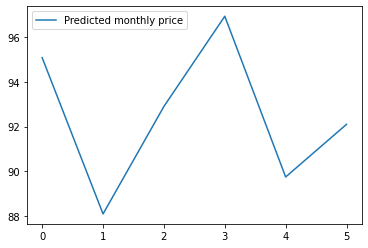

In [51]:
plt.plot(predicted_cases, label='Predicted monthly price')
plt.legend();